In [3]:
import glob
import sys

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append("../image")
import krige


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [4]:
def process_radar_csv(fname):
    csv_df = pd.read_csv(fname)
    del csv_df["Unnamed: 0"]
    start = fname.index('KOKX')
    csv_df['Date_Time'] = pd.to_datetime(fname[start+4:start+19],format='%Y%m%d_%H%M%S')
    return csv_df

def load_radar_night(night, next_night):
    radar_dir = "-".join(night.split("-")[:2]) + "/" + night.split("-")[-1]
    next_radar_dir = "-".join(next_night.split("-")[:2]) + "/" + next_night.split("-")[-1]
    print(radar_dir, next_radar_dir)
    fnames = glob.glob("../radar/data/{}/*.filtered.csv".format(radar_dir))\
           + glob.glob("../radar/data/{}/*.filtered.csv".format(next_radar_dir))
    radar_levels = pd.concat((process_radar_csv(fname)\
                              for fname in fnames))

    t_filt = (radar_levels.Date_Time >= "{} 21:00".format(night)) &\
             (radar_levels.Date_Time <= "{} 06:00".format(next_night))

    radar_levels = radar_levels[t_filt]
    grouped = radar_levels.groupby(["lon", "lat"])
    radar_levels = grouped.apply(lambda g: g.set_index("Date_Time").dbzh.resample('10T').mean().reset_index())\
                       .reset_index()
    return radar_levels

In [17]:
import geopandas as gpd
import shapely.geometry
def plot_levels(radar_levels, night, ax):
    filt_levels = radar_levels[radar_levels.Date_Time > "{} 23:30:00".format(night)]
    vals = gpd.GeoDataFrame(filt_levels.groupby(["lon", "lat"]).dbzh.mean().to_frame().reset_index())
    vals.geometry = vals[["lon", "lat"]].apply(shapely.geometry.Point, axis=1)
    mgd =  gpd.sjoin(vals, krige.ch_df)
    krige.in_frame.plot(ax=ax)
    krige.out_reset.plot(ax=ax)
    #tribute_area.plot(ax=ax, color='red')
    mgd.plot('dbzh', ax=ax, alpha=.8)
    ax.set_title(night + " night")

In [18]:
nights = ["2017-09-28", "2017-09-29", "2017-09-30", "2017-10-01", "2017-10-02", "2017-10-03"]
levels_by_night = {}
for night, next_night in zip(nights, nights[1:]):
    levels_by_night[night] = load_radar_night(night, next_night)

2017-09/28 2017-09/29
2017-09/29 2017-09/30
2017-09/30 2017-10/01
2017-10/01 2017-10/02
2017-10/02 2017-10/03


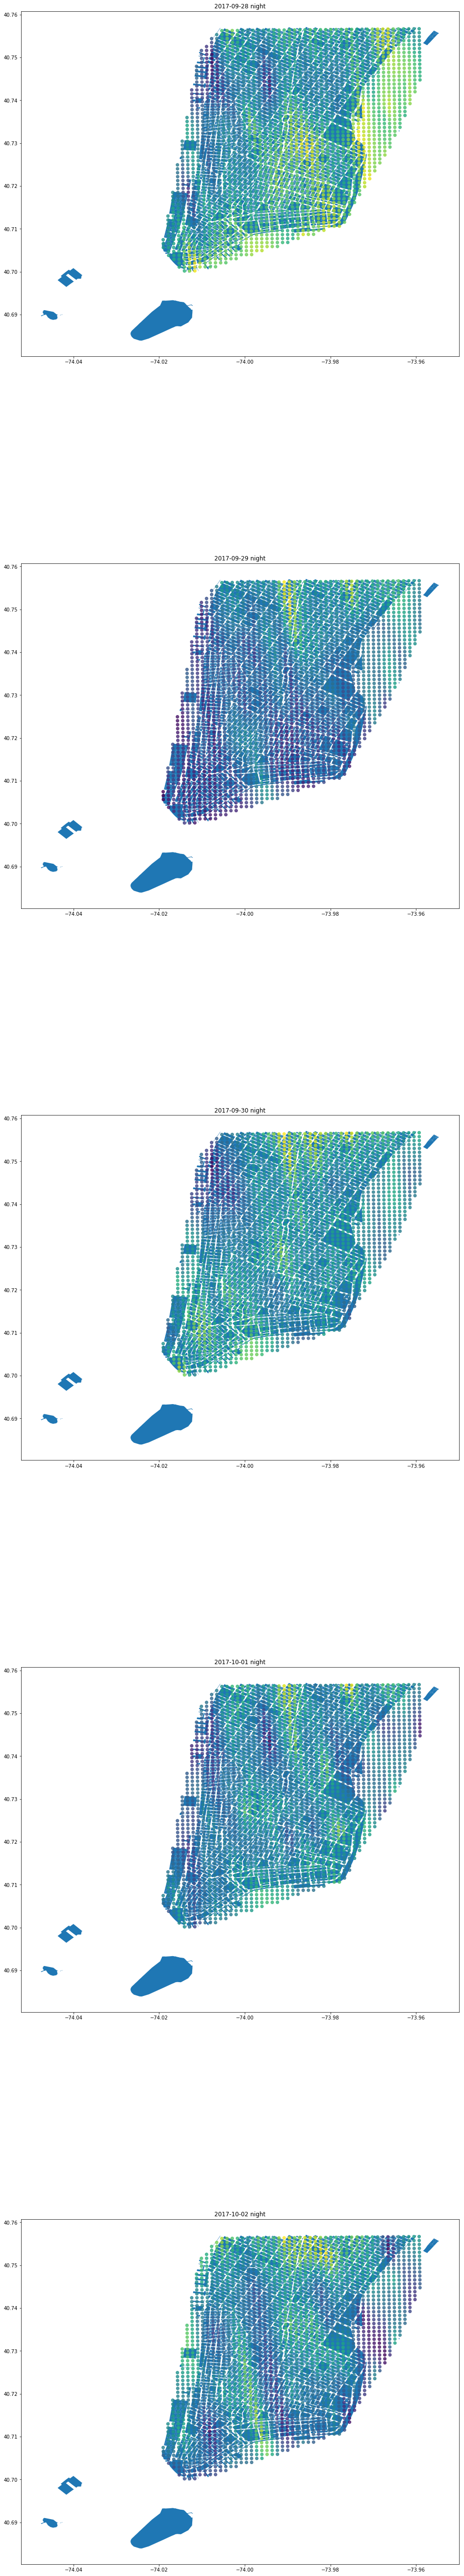

In [19]:
fig, axes = plt.subplots(5, 1, figsize=(16, 100))
axes = axes.flatten()
for ax, night in zip(axes, nights[:-1]):
    plot_levels(levels_by_night[night], night, ax)